In [86]:
import cv2
import numpy as np
import os
import math
from scipy.optimize import least_squares
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

path_root = '/home/xingguang/Documents/ECE661/hw10/Task2_Images'

In [80]:
def normlize(pt):
    center = np.average(pt, axis=0)
    npt = pt - center
    d = np.sqrt(np.sum(npt ** 2, axis=1))
    s = np.sqrt(2)/np.average(d)
    npt = s * npt
    T = np.array([[s, 0, -s*center[0]], [0, s, -s*center[1]], [0, 0, 1]])
    return npt, T


def findF(pts1, pts2, T1, T2):
    def A_unit(p1, p2):
        x, y = p1[0], p1[1]
        x_, y_ = p2[0], p2[1]
        return np.asarray([[x*x_, y*x_, x_, x*y_, y*y_, y_, x, y, 1]])
    A_list = [A_unit(pts1[i], pts2[i]) for i in range(pts1.shape[0])]
    A = np.concatenate(A_list, axis=0)
    u, d, vt = np.linalg.svd(A)
    F = vt[-1].reshape((3, 3))
    U, D, VT = np.linalg.svd(F)
    DD = np.diag([D[0], D[1], 0])
    nF = U.dot(np.dot(DD, VT))
    denormalized_F = np.dot(T2.T, np.dot(nF, T1))
    return denormalized_F


def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])


def findP(F, e2):
    P1 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
    P2 = np.hstack([np.dot(skew(e2), F), e2.reshape((-1,1))])
    return P1, P2

In [3]:
def definePQRS(width, height):
    P = [0, 0]
    Q = [0, height]
    S = [width, 0]
    R = [width, height]
    return np.asarray([P, Q, S, R])


def projTransform(H, source):
    nps = source.shape[0]
    source_rep = np.concatenate((source, np.ones((nps,1))), axis=1)
    t_homo = np.matmul(H, source_rep.T).T
    t_norm = t_homo / t_homo[:,2].reshape((nps,1))
    return t_norm[:,:2]
    
    
def projResizeRange(source, H):
    corners = definePQRS(source.shape[1], source.shape[0])
    expanded = projTransform(H, corners)
    l, r = np.amin(expanded[:, 0]), np.amax(expanded[:, 0])
    t, b = np.amin(expanded[:, 1]), np.amax(expanded[:, 1])
    
    height, width = (b-t), (r-l)
    H = np.linalg.inv(H)
    out = np.zeros((int(b-t), int(r-l), 3), dtype=source.dtype)
    print("Size of rectified image is:", out.shape)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            coor_source = np.asarray([[j+l, i+t]])
            coor_target = projTransform(H, coor_source).squeeze()
            h, w = int(coor_target[1]), int(coor_target[0])
            if 0 <= h < source.shape[0] and 0 <= w <source.shape[1]:
                out[i,j,:] = source[h, w,:]
    translation = np.array([[1, 0, -l], [0, 1, -t], [0, 0, 1]])
    return out, translation

In [4]:
def filter_corner(edges, pts):
    l, r = np.amin(pts[:, 0]), np.amax(pts[:, 0])
    t, b = np.amin(pts[:, 1]), np.amax(pts[:, 1])
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if j < l or j > r or i < t or i > b:
                edges[i,j] = 0
    return edges


def drawPoints(img, p, c=(0, 0, 255)):
    out = img.copy()
    for i in range(len(p)):
        point = (int(p[i][0]), int(p[i][1]))
        out = cv2.circle(out, point, radius=10, color=c, thickness=-1)
    return out


def drawLines(img, p_start, p_end, color=(0,255,0)):
    image = np.copy(img)
    for i in range(len(p_start)):
        image = cv2.circle(image, p_start[i], 3, color, 1)
        image = cv2.circle(image, p_end[i], 3, color, 1)
        image = cv2.line(image, p_start[i], p_end[i], color, 2) 
    return image


def stack_img(im1, im2):
    h1, w1 = im1.shape[0], im1.shape[1]
    h2, w2 = im2.shape[0], im2.shape[1]
    nh = min(h1, h2)
    h1_t = 0
    h1_b = h1_t + nh
    h2_t = 0
    h2_b = h2_t + nh
    w = w1 + w2
    lps = [(0, i) for i in range(0, nh, int(nh/10))]
    rps = [(w-1, i) for i in range(0, nh, int(nh/10))]
    if len(im1.shape) == 3:
        stacked_im = np.zeros((nh, w, 3)).astype(np.uint8)
        stacked_im[:, :w1, :] = im1[h1_t:h1_b, :, :]
        stacked_im[:, w1:w, :] = im2[h2_t:h2_b, :, :]
        stacked_im = drawLines(stacked_im, lps, rps)
    else:
        stacked_im = np.zeros((nh, w)).astype(np.uint8)
        stacked_im[:, :w1] = im1[h1_t:h1_b, :]
        stacked_im[:, w1:w] = im2[h1_t:h1_b, :]
        # stacked_im = drawLines(stacked_im, lps, rps, color=255)
    return stacked_im

In [5]:
img1 = cv2.imread("i1.jpg")
img2 = cv2.imread("i2.jpg")
pts1 = np.array([[125, 318],[163,456],[330,239],[423,617],[421,749],[663,463],[620,605],[406, 411]])
pts2 = np.array([[139, 315],[175,457],[355,251],[378,646],[382,779],[657,508],[612,649],[400, 431]])
npt1, T1 = normlize(pts1)
npt2, T2 = normlize(pts2)

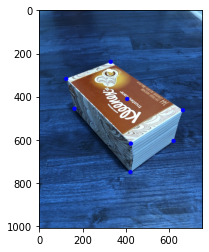

In [6]:
i1 = drawPoints(img1, pts1)
plt.imshow(i1)

In [50]:
def rectify(img1, img2, pts1, pts2, F):
    height = img1.shape[0]
    width = img1.shape[1]
    num_pts = len(pts1)
    hp1 = np.hstack((pts1, np.ones((num_pts, 1))))
    hp2 = np.hstack((pts2, np.ones((num_pts, 1))))
    e1 = null_space(F).flatten()
    e1 /= e1[2]
    e2 = null_space(F.T).flatten()
    e2 /= e2[2]

    theta = np.arctan(-1 * (e2[1] - height/2) / (e2[0] - width/2))
    f = np.cos(theta) * (e2[0] - width/2) - np.sin(theta) * (e2[1] - height/2)

    R = np.asarray([[np.cos(theta), -np.sin(theta), 0], 
                    [np.sin(theta), np.cos(theta), 0], 
                    [0, 0, 1]])
    T = np.asarray([[1, 0, -width/2], 
                [0, 1, -height/2], 
                [0, 0, 1]])
    G = np.asarray([[1, 0, 0],[0, 1, 0],[-1/f, 0, 1]])
    H2 = np.dot(np.dot(np.dot(np.linalg.inv(T), G), R), T)

    M = np.dot(skew(e2), F) + np.dot(e2.reshape((-1, 1)), np.asarray([[1, 1, 1]]))
    new_hp1 = np.dot(np.dot(H2, M), hp1.T).T
    new_hp1 = new_hp1 / new_hp1[:, -1].reshape((-1, 1))
    new_hp2 = np.dot(H2, hp1.T).T
    new_hp2 = new_hp2 / new_hp2[:, -1].reshape((-1, 1))

    W = new_hp1.copy()
    b = new_hp2[:, 0].copy()
    a = np.dot(np.linalg.pinv(W), b)
    H_a = np.asarray([[a[0], a[1], a[2]], [0, 1, 0], [0, 0, 1]])
    H1 = np.dot(np.dot(H_a, H2), M)
    H2 = H2 / H2[-1, -1]
    H1 = H1 / H1[-1, -1]
    return H1, H2, e1, e2


def align_imgs(img1, img2, H1, H2):
    new_img1, translation1 = projResizeRange(img1, H1)
    new_img2, translation2 = projResizeRange(img2, H2)
    hoffset1 = translation1[1, 2]
    hoffset2 = translation2[1, 2]
    mismatch = abs(hoffset1-hoffset2)
    nT = np.array([[1,0,0], [0,1,mismatch], [0,0,1]])
    mismatch = int(mismatch)
    nH1 = np.dot(translation1, H1)
    nH2 = np.dot(translation2, H2)
    if hoffset1 < hoffset2:
        rct1 = np.zeros((new_img1.shape[0]+mismatch, new_img1.shape[1], 3), dtype=np.uint8)
        rct1[mismatch:, :, :] = new_img1
        rct2 = new_img2
        nH1 = np.dot(nT, nH1)
    elif hoffset1 > hoffset2:
        rct2 = np.zeros((new_img2.shape[0]+mismatch, new_img2.shape[1], 3), dtype=np.uint8)
        rct2[mismatch:, :, :] = new_img2
        rct1 = new_img1
        nH2 = np.dot(nT, nH2)
    return rct1, rct2, nH1, nH2

True

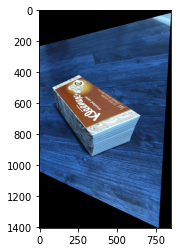

In [130]:
F = findF(npt1, npt2, T1, T2)
H1, H2, e1, e2 = rectify(img1, img2, pts1, pts2, np.copy(F))
rct1, rct2, nH1, nH2 = align_imgs(img1, img2, H1, H2)
plt.imshow(rct1)
cv2.imwrite("rct1.jpg", rct1)

True

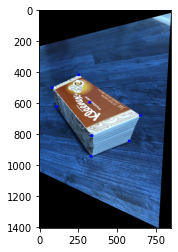

In [131]:
new_pts1 = projTransform(nH1, pts1)
i1 = drawPoints(rct1, new_pts1)
plt.imshow(i1)
cv2.imwrite("rct2.jpg", rct2)

In [29]:
new_pts1 = projTransform(nH1, pts1)
new_pts2 = projTransform(nH2, pts2)
g1 = cv2.cvtColor(rct1, cv2.COLOR_BGR2GRAY)
g1 = cv2.GaussianBlur(g1, (3,3), 3)
edges1 = cv2.Canny(g1, 255*1.5, 255)
edges1 = filter_corner(edges1, new_pts1)

g2 = cv2.cvtColor(rct2, cv2.COLOR_BGR2GRAY)
g2 = cv2.GaussianBlur(g2, (3,3), 3)
edges2 = cv2.Canny(g2, 255*1.5, 255)
edges2 = filter_corner(edges2, new_pts2)

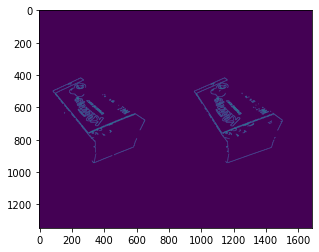

In [30]:
stacked_edges = stack_img(edges1, edges2)
cv2.imwrite("canny.jpg", stacked_edges)
plt.imshow(stacked_edges)

In [144]:
def findKPs(img, edges, max_num = 500):
    cy_x = np.argwhere(edges > 100)
    edges_coord =np.hstack([cy_x[:,1, np.newaxis], cy_x[:,0, np.newaxis]])
    num_p = len(edges_coord)
    print(num_p)
    descriptor = cv2.xfeatures2d.SIFT_create()
    kp = [cv2.KeyPoint(p[0],p[1],20) for p in edges_coord]
    pos, feature = descriptor.compute(img, kp)
    coors =[[p.pt[0],p.pt[1]] for p in pos]
    pos = np.array(coors, dtype=np.int)
    return pos,feature


def NCC(feat1, feat2):
    N,M=feat1.shape[0], feat2.shape[0]
    
    window_m1 = np.mean(feat1, axis=-1,keepdims=True)
    window_m2 = np.mean(feat2, axis=-1,keepdims=True)
    
    f1 = feat1 - window_m1
    f2 = feat2 - window_m2
    
    f1_tile = np.tile(f1[:,None,:],(1, M, 1))
    f2_tile = np.tile(f2[None,:,:],(N, 1, 1))
    
    nominator = (f1_tile * f2_tile).sum(axis=-1)
    denominator = np.maximum(((f1_tile**2).sum(axis=-1))*((f2_tile**2).sum(axis=-1)),1e-8)
    return -nominator/np.sqrt(denominator)


def matching(f1, f2, top_match):

    matching=[]
    for i in range(f1.shape[0]):
        matrix = NCC(f1[i:i+1],f2)
        min_idx = matrix[0].argmin(axis=-1)
        min_dis = matrix[0][min_idx]
        matching.append([min_dis, i, min_idx])
    
    matching = sorted(matching, key=lambda x: x[0])
    origin_idx = [ matching[i][1] for i in range(min(top_match, len(f1)))]
    target_idx = [ matching[i][2] for i in range(min(top_match, len(f1)))]
    return origin_idx,target_idx


def correspondence(kp1, kp2, f1, f2):

    left_kp_matched, right_kp_matched = [],[]
    for p, f in zip(kp1,f1):
        mask = (kp2[:,1] < (p[1] + 1)) & (kp2[:,1] > (p[1] - 1))
        candidates_p = kp2[mask]
        candidates_f = f2[mask]
        if len(candidates_p)>0:
            left_idx, right_idx = matching(f[None,:],candidates_f,1)
            left_kp_matched.append(p)
            right_kp_matched.append(candidates_p[right_idx[0]])
    return np.array(left_kp_matched), np.array(right_kp_matched)


def triangular3D(p1, p2, P1, P2):
    p1_cam1, p2_cam1, p3_cam1 = P1[0], P1[1], P1[2]
    p1_cam2, p2_cam2, p3_cam2 = P2[0], P2[1], P2[2]
    A = []
    for i in range(p1.shape[0]):
        x1, y1, x2, y2 = p1[i,0], p1[i,1], p2[i,0], p2[i,1]
        sub_A = []
        sub_A.append(x1*p3_cam1 - p1_cam1)
        sub_A.append(y1*p3_cam1 - p2_cam1)
        sub_A.append(x2*p3_cam2 - p1_cam2)
        sub_A.append(y2*p3_cam2 - p2_cam2)
        sub_A = np.array(sub_A)
        A.append(sub_A)

    A = np.array(A)
    ATA = np.einsum('ijk,ikm->ijm', np.transpose(A,(0,2,1)),A)
    U, d, Vh = np.linalg.svd(ATA)
    X = Vh[:,-1,:]
    X = X / X[:,-1, np.newaxis]
    return X

In [140]:
kp1, feature1 = findKPs(rct1, edges1)
kp2, feature2 = findKPs(rct2, edges2)

6854
7103


In [145]:
matched1, matched2 = correspondence(kp1, kp2, feature1, feature2)

In [135]:
sel = np.random.choice(len(matched1), size=(128,), replace=False)
selected1 = matched1[sel]
selected2 = matched2[sel]
for (x1,y1), (x2,y2) in zip(selected1, selected2):
    cv2.circle(stacked_img, (int(x1),int(y1)),5, (255,0,0),thickness=2)
    cv2.circle(stacked_img, (int(x2)+rct1.shape[1],int(y2)),5, (0,255,0),thickness=2)
    cv2.line(stacked_img, (int(x1),int(y1)),(int(x2)+rct1.shape[1],int(y2)), (0,255,255),thickness=2)

True

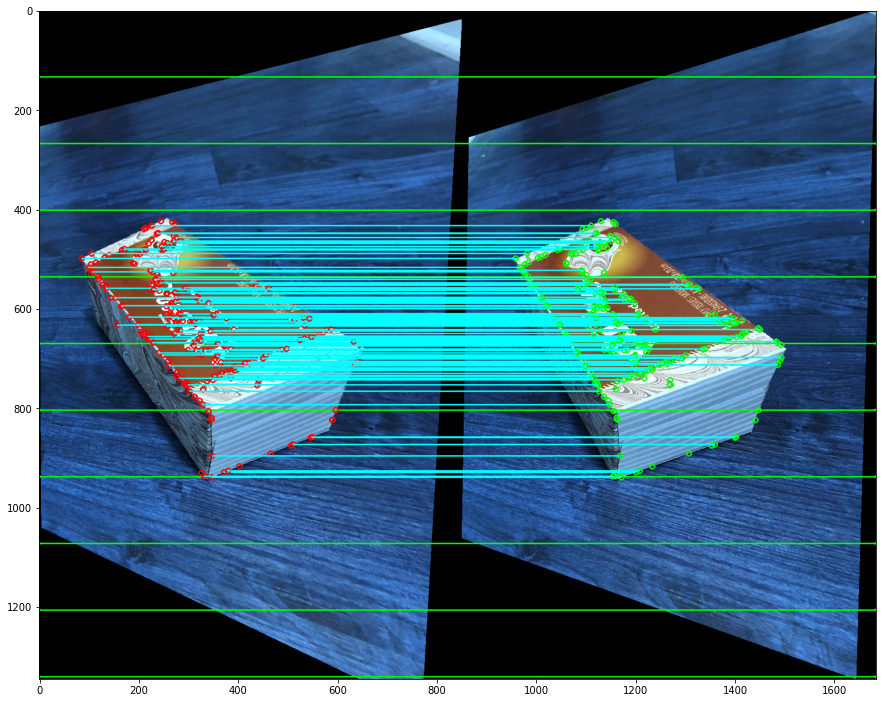

In [137]:
plt.figure(figsize=(15,25))
plt.imshow(stacked_img)
cv2.imwrite('corresp.jpg', stacked_img)

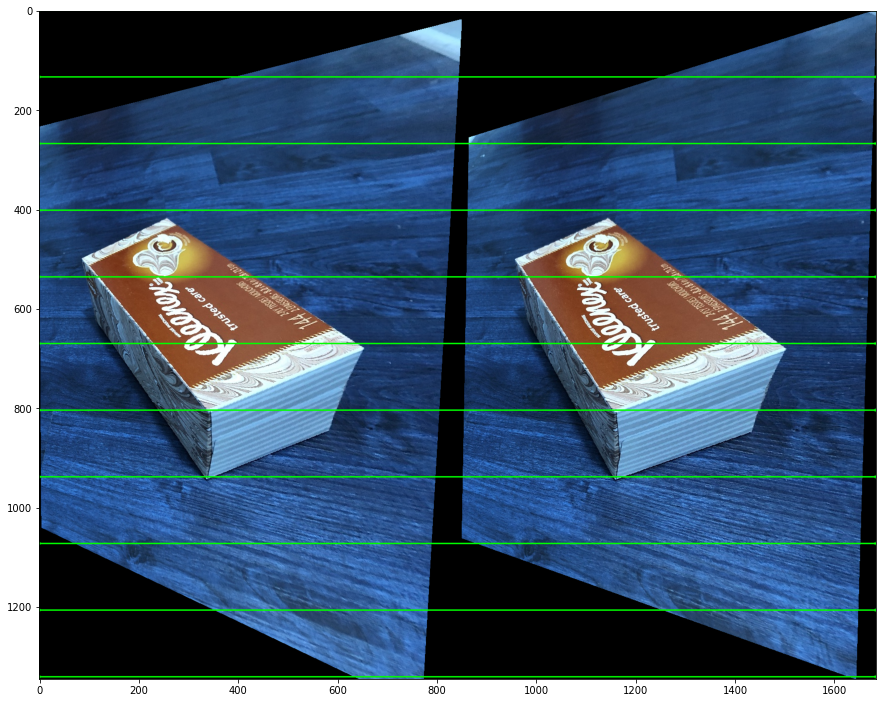

In [132]:
stacked_img = stack_img(rct1, rct2)
plt.figure(figsize=(15,25))
plt.imshow(stacked_img)

In [83]:
P1, P2 = findP(F, e2)

In [138]:
X = triangular3D(pts1, p2, P1, P2)

(8, 4, 4) float64


In [85]:
coor3d

array([[1.03567976e+02, 2.63901025e+02, 8.28574712e-01, 1.00000000e+00],
       [1.01159992e+02, 2.83192392e+02, 6.20499710e-01, 1.00000000e+00],
       [1.43322656e+02, 1.03801220e+02, 4.34311246e-01, 1.00000000e+00],
       [1.46101017e+02, 2.13107555e+02, 3.45392191e-01, 1.00000000e+00],
       [1.34290745e+02, 2.38916458e+02, 3.18980163e-01, 1.00000000e+00],
       [1.57468716e+02, 1.10210331e+02, 2.37462266e-01, 1.00000000e+00],
       [1.47259196e+02, 1.43823609e+02, 2.37452061e-01, 1.00000000e+00],
       [1.46997009e+02, 1.48811928e+02, 3.62060927e-01, 1.00000000e+00]])

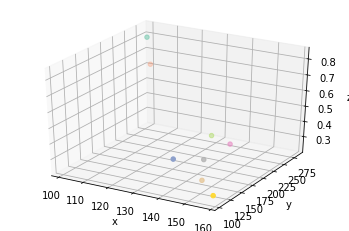

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(X[:,0],X[:,1],X[:,2], cmap=plt.cm.get_cmap('Set2', len(X)), c=np.arange(len(X)))

(128, 4, 4) float64


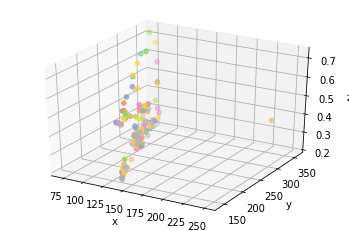

In [97]:
X1 = triangular3D(selected1, selected2, P1, P2)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(X1[:,0],X1[:,1],X1[:,2], cmap=plt.cm.get_cmap('Set2', len(X1)), c=np.arange(len(X1)))

In [128]:
def errfunc(F, pts1, pts2):
    #print('F in lm= {}'.format(F))
    F = np.append(F,1).reshape(3,3)
    U, D, VT = np.linalg.svd(F)
    DD = np.diag([D[0], D[1], 0])
    F = U.dot(np.dot(DD, VT))
    e2 = null_space(F.T).flatten()
    e2 /= e2[-1]
    P1, P2 = findP(F, e2)

    world_pts=triangular3D(pts1, pts2, P1, P2)

    proj1 = np.dot(P1, world_pts.T)
    proj1 /= proj1[2]
    proj2 = np.dot(P2,world_pts.T)
    proj2 /= proj2[2]
    err = np.append(proj1[:2]-pts1[:2], proj2[:2]-pts2[:2])
    return err

def lm(pts1, pts2, F):
    pts1=np.array(pts1).T
    pts2=np.array(pts2).T

    F = F.flatten()
    F = F[:-1].reshape(8,1)

    ans=optimize.leastsq(errfunc,F,args=(pts1,pts2))
    F = F.flatten()
    print('change = ', ans[0] - F)

    F=np.append(ans[0],1).reshape(3,3)
    e2 = null_space(F.T).flatten()
    e2 /= e2[-1]
    _, P2 = findP(F, e2)
    return F, P2

In [129]:
loss_f = errfunc(F.flatten()[:-1], pts1, pts2)

(8, 4, 4) float64


ValueError: operands could not be broadcast together with shapes (2,8) (2,2) 

In [121]:
FF = F.flatten()[:-1]

In [123]:
F = np.append(FF,1).reshape(3,3)

dtype('float64')

In [124]:
e2 = null_space(F.T)

In [125]:
e2

array([], shape=(3, 0), dtype=float64)

In [120]:
F

array([[ 2.48033815e-07,  2.96335126e-06, -1.43152850e-03],
       [-3.12117003e-06,  2.85027147e-07,  5.43501029e-03],
       [ 1.00015249e-03, -5.71263572e-03,  1.40228876e-01]])